# Predicting Facial Points - Kaggle
The following code is for the kaggle competition linked [here](https://www.kaggle.com/c/facial-keypoints-detection).

## Data files

1. training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
2. test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


### Helper Functions to Load Files

In [2]:
def load(test=False, cols=None):
    
    fname = "test.csv" if test else "training.csv"
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(test=False, cols=None):
    
    X, y, columns = load(test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

## Load Training Data

In [3]:
X, y, columns = load2d(test=False)
columns = np.array(list(columns[:-1]))
columns

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y',
       'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='<U25')

## Visualizing Some Data Points

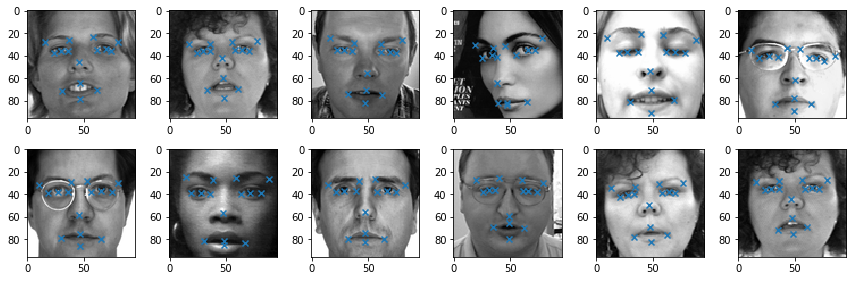

In [16]:
import seaborn as sns
plt.figure(0, figsize=(12,4))
for i in range(1, 13):
    plt.subplot(2,6,i)
    plt.imshow(X[i, :, :, 0], cmap="gray")
    plt.scatter(y[i, range(0, 30, 2)], y[i, range(1, 30, 2)], marker='x')
    #print(y[i, range(0, 30, 2)], y[i, range(1, 30, 2)])
plt.tight_layout()
plt.show()

## Extract Test data

In [5]:
X_test, _, __ = load2d(test=True)
X_test.shape

ImageId    1783
Image      1783
dtype: int64


(1783, 96, 96, 1)

## Convolutional Neural Network

In [6]:
model = Sequential()

model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(96, 96, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(36, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(48, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, 3))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 24)        624       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 36)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 36)        0         
__________

## Training Time

In [7]:
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

epochs = 300

hist = model.fit(X, y, epochs=epochs, 
                 validation_split=0.2, callbacks=[checkpointer], verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/300
Epoch 00000: val_loss improved from inf to 3028.18669, saving model to face_model.h5
11s - loss: 506.1606 - acc: 0.5999 - val_loss: 3028.1867 - val_acc: 0.7079
Epoch 2/300
Epoch 00001: val_loss improved from 3028.18669 to 372.34906, saving model to face_model.h5
8s - loss: 260.1321 - acc: 0.7009 - val_loss: 372.3491 - val_acc: 0.7079
Epoch 3/300
Epoch 00002: val_loss improved from 372.34906 to 204.55008, saving model to face_model.h5
8s - loss: 202.8395 - acc: 0.7009 - val_loss: 204.5501 - val_acc: 0.7103
Epoch 4/300
Epoch 00003: val_loss improved from 204.55008 to 125.58391, saving model to face_model.h5
8s - loss: 187.4219 - acc: 0.7021 - val_loss: 125.5839 - val_acc: 0.7079
Epoch 5/300
Epoch 00004: val_loss improved from 125.58391 to 92.93780, saving model to face_model.h5
9s - loss: 153.4749 - acc: 0.7015 - val_loss: 92.9378 - val_acc: 0.7079
Epoch 6/300
Epoch 00005: val_loss did not improve
8s - loss: 140.0897 - acc: 0.702

## Prediction Time

In [8]:
y_test = model.predict(X_test)
print(y_test.shape)

(1783, 30)


## Processing Data to Meet Submission Format

In [9]:
id_lookup_frame = pd.read_csv("IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [10]:
y_res = []
j = 0
k = 0
m = 0
for i in range(1, 1784):
    img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
    if img.shape[0] == 30:
        y_res += list(y_test[i-1,:])
        j += 30
    else:
        slice_img = y_test[i-1, :]
        y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
        k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
y_res = np.array(y_res)
y_res.shape

(27124,)

In [11]:
result_dict = {
    "RowId": range(1,27125),
    "Location": y_res%96
}
result_df = pd.DataFrame(result_dict, )
result_df.to_csv("result.csv", index=False, columns=["RowId", "Location"])